# Import & Setup

In [ ]:
!pip show diffusers
!pip show accelerate
!pip show transformers
!pip show torch
!pip show datasets
!pip show beautifulsoup4
!pip show ftfy
!pip show safetensors
!pip show torchvision

Name: diffusers
Version: 0.36.0
Summary: State-of-the-art diffusion in PyTorch and JAX.
Home-page: https://github.com/huggingface/diffusers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/diffusers/graphs/contributors)
Author-email: diffusers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.12/dist-packages
Requires: filelock, httpx, huggingface-hub, importlib_metadata, numpy, Pillow, regex, requests, safetensors
Required-by: 
Name: accelerate
Version: 1.12.0
Summary: Accelerate
Home-page: https://github.com/huggingface/accelerate
Author: The HuggingFace team
Author-email: zach.mueller@huggingface.co
License: Apache
Location: /usr/local/lib/python3.12/dist-packages
Requires: huggingface_hub, numpy, packaging, psutil, pyyaml, safetensors, torch
Required-by: peft
Name: transformers
Version: 4.57.3
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://gi

In [ ]:
import os, math, random, textwrap
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from datasets import load_dataset
from bs4 import BeautifulSoup
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
from transformers import AutoModel, AutoTokenizer
from transformers import AutoTokenizer as GPT2Tokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, DDIMScheduler, DDPMScheduler
from accelerate import Accelerator
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np


CFG_DROP_PROB = 0.10

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE  = torch.float16 if DEVICE == "cuda" else torch.float32
print("DEVICE:", DEVICE, "| DTYPE:", DTYPE)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.7 MB/s eta 0:00:00


Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


DEVICE: cuda | DTYPE: torch.float16


In [ ]:
# Path & Hyperparameter
ROOT = "/content/drive/MyDrive/Mutimodal_Sequential_prediction"
CKPT_DIR = os.path.join(ROOT, "checkpoints")
RES_DIR  = os.path.join(ROOT, "results")
os.makedirs(CKPT_DIR, exist_ok=True)
os.makedirs(RES_DIR,  exist_ok=True)

#Model
SD_MODEL_ID = "runwayml/stable-diffusion-v1-5"
SEQ_CKPT_PATH = os.path.join(CKPT_DIR, "MultimodalSequenceModel.pt")
CACHE_PATH    = os.path.join(CKPT_DIR, "decoder_cache.pt")

DEC_CKPT_PATH = os.path.join(CKPT_DIR, "Multimodal_Decoders.pt")

latent_dim = 512
MAX_LEN = 64

#sequence model
SEQ_BATCH  = 2
SEQ_EPOCHS = 10
SEQ_LR     = 1e-4

# Cache build
CACHE_ITEMS = 5000

#Unet Decoder
DEC_BATCH   = 2
DEC_EPOCHS  = 5
DEC_LR      = 1e-4
GRAD_ACCUM  = 2

#GLOBAL accelerator
from accelerate import Accelerator
MP = "bf16" if (DEVICE=="cuda" and torch.cuda.is_bf16_supported()) else ("fp16" if DEVICE=="cuda" else "no")
accelerator = Accelerator(mixed_precision=MP, gradient_accumulation_steps=GRAD_ACCUM)
device = accelerator.device
print("GLOBAL mixed_precision:", MP, "| grad_accum:", GRAD_ACCUM, "| device:", device)

CFG_DROP_PROB = 0.10

print("SEQ_CKPT_PATH:", SEQ_CKPT_PATH)
print("CACHE_PATH   :", CACHE_PATH)
print("DEC_CKPT_PATH:", DEC_CKPT_PATH)


GLOBAL mixed_precision: bf16 | grad_accum: 2 | device: cuda
SEQ_CKPT_PATH: /content/drive/MyDrive/Mutimodal_Sequential_prediction/checkpoints/MultimodalSequenceModel.pt
CACHE_PATH   : /content/drive/MyDrive/Mutimodal_Sequential_prediction/checkpoints/decoder_cache.pt
DEC_CKPT_PATH: /content/drive/MyDrive/Mutimodal_Sequential_prediction/checkpoints/Multimodal_Decoders.pt


# Dataset

In [ ]:
bert_tok = AutoTokenizer.from_pretrained("bert-base-uncased")

img_tf_224 = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

img_tf_512 = transforms.Compose([
    transforms.Resize((512,512)),
    transforms.ToTensor()
])

def parse_gdi(text):
    soup = BeautifulSoup(text, "html.parser")
    return [x.get_text().strip() for x in soup.find_all("gdi")]

class StoryDataset(torch.utils.data.Dataset):
    def __init__(self, split="train", max_len=64):
        self.ds = load_dataset("daniel3303/StoryReasoning", split=split)
        self.max_len = max_len

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, i):
        s = self.ds[i]
        texts = (parse_gdi(s["story"]) + [""] * 4)[:4]

        imgs224 = torch.stack([img_tf_224(s["images"][j]) for j in range(4)])
        gt_img512 = img_tf_512(s["images"][3])

        ctx = bert_tok(
            texts[:3],
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )

        return {
            "imgs224": imgs224,                 # (4,3,224,224)
            "ids": ctx["input_ids"],            # (3,L)
            "mask": ctx["attention_mask"],      # (3,L)
            "texts": texts,                     # list[str] length (4))
            "gt_img512": gt_img512              # (3,512,512)
        }

ex = StoryDataset("train", MAX_LEN)[0]
print("keys:", ex.keys())
print("imgs224:", tuple(ex["imgs224"].shape), "ids:", tuple(ex["ids"].shape), "gt_img512:", tuple(ex["gt_img512"].shape))


# Models

In [ ]:
class ImageEncoder(nn.Module):
    def __init__(self, d):
        super().__init__()
        bb = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        self.backbone = nn.Sequential(*list(bb.children())[:-1])
        for p in self.backbone.parameters():
            p.requires_grad = False
        self.fc = nn.Linear(2048, d)
    def forward(self, x):
        x = self.backbone(x).squeeze(-1).squeeze(-1)
        return self.fc(x)

class TextEncoder(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.bert = AutoModel.from_pretrained("bert-base-uncased")
        self.fc = nn.Linear(768, d)
    def forward(self, ids, mask):
        out = self.bert(ids, attention_mask=mask)
        return self.fc(out.last_hidden_state[:, 0])

class TemporalFusion(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.norm_i = nn.LayerNorm(d)
        self.norm_t = nn.LayerNorm(d)
        self.fuse = nn.Sequential(
            nn.Linear(2*d, d),
            nn.GELU(),
            nn.LayerNorm(d),
            nn.Dropout(0.1)
        )
        self.gate = nn.Sequential(nn.Linear(2*d, d), nn.Sigmoid())
    def forward(self, zi, zt):
        zi = self.norm_i(zi); zt = self.norm_t(zt)
        cat = torch.cat([zi, zt], dim=-1)
        fused = self.fuse(cat)
        g = self.gate(cat)
        return g * fused + (1-g) * (0.5*(zi+zt))

class MultimodalSequenceModel(nn.Module):
    def __init__(self, d=512):
        super().__init__()
        self.img_enc = ImageEncoder(d)
        self.txt_enc = TextEncoder(d)
        self.fusion = TemporalFusion(d)
        self.temporal = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d, nhead=8, batch_first=True, norm_first=True),
            num_layers=3
        )
    def encode_sequence(self, imgs, ids, mask, return_tokens=False):
        z = []
        for t in range(3):
            zi = self.img_enc(imgs[:, t])
            zt = self.txt_enc(ids[:, t], mask[:, t])
            z.append(self.fusion(zi, zt))
        z = torch.stack(z, dim=1)  # (B,3,512)
        h = self.temporal(z)       # (B,3,512)
        mem = h[:, -1]
        return (mem, h) if return_tokens else mem

def mem_collapse_loss(tokens):
    x = tokens.reshape(tokens.size(0), -1)
    if x.size(0) < 2:
        return x.new_tensor(0.0)
    std = x.std(dim=0)
    return F.relu(0.05 - std).mean()

print("Sequence model defined.")


Sequence model defined.


#Training Loop for Sequence Models

In [ ]:
W_TEXT, W_IMG, W_MEM = 1.0, 1.0, 0.2

accelerator = Accelerator(mixed_precision="fp16" if torch.cuda.is_available() else "no")
device = accelerator.device

model = MultimodalSequenceModel(latent_dim=latent_dim)
optimizer = torch.optim.AdamW(model.parameters(), lr=SEQ_LR)

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model.eval()
for p in clip_model.parameters():
    p.requires_grad = False
clip_model.to(device)

train_dl = DataLoader(StoryDataset("train", MAX_LEN), batch_size=SEQ_BATCH, shuffle=True, num_workers=2, pin_memory=True)
val_dl   = DataLoader(StoryDataset("test",  MAX_LEN), batch_size=SEQ_BATCH, shuffle=False, num_workers=2, pin_memory=True)

model, optimizer, train_dl, val_dl = accelerator.prepare(model, optimizer, train_dl, val_dl)

def token_accuracy(logits, tgt):
    pred = logits.argmax(-1)
    m = (tgt != tokenizer.pad_token_id)
    if m.sum().item() == 0:
        return 0.0
    return (pred[m] == tgt[m]).float().mean().item()

train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(SEQ_EPOCHS):
    model.train()
    tr_loss, tr_acc = 0.0, 0.0

    for batch in train_dl:
        imgs   = batch["imgs"].to(device)
        ids    = batch["ids"].to(device)
        mask   = batch["mask"].to(device)
        tgt    = batch["tgt"].to(device)
        gt_img = batch["gt_img"].to(device)
        gt_txt = batch["gt_txt"]

        mem = model.encode_sequence(imgs, ids, mask)

        logits = model.predict_text(mem, tgt[:, :-1])
        loss_txt = F.cross_entropy(
            logits.reshape(-1, logits.size(-1)),
            tgt[:, 1:].reshape(-1),
            ignore_index=tokenizer.pad_token_id
        )
        acc = token_accuracy(logits, tgt[:, 1:])

        with torch.no_grad():
            clip_inputs = clip_processor(
                text=list(gt_txt),
                images=gt_img,
                return_tensors="pt",
                padding=True,
                truncation=True,
                do_rescale=False
            ).to(device)
            clip_img = clip_model(**clip_inputs).image_embeds

        pred_img_lat = model.predict_image_latent(mem)
        loss_img = F.mse_loss(F.normalize(pred_img_lat, dim=-1), F.normalize(clip_img, dim=-1))

        loss_mem = mem_collapse_loss(mem)
        loss = W_TEXT*loss_txt + W_IMG*loss_img + W_MEM*loss_mem

        optimizer.zero_grad(set_to_none=True)
        accelerator.backward(loss)
        optimizer.step()

        tr_loss += loss.item()
        tr_acc += acc

    train_losses.append(tr_loss / len(train_dl))
    train_accs.append(tr_acc / len(train_dl))

    model.eval()
    vl_loss, vl_acc = 0.0, 0.0
    with torch.no_grad():
        for batch in val_dl:
            imgs   = batch["imgs"].to(device)
            ids    = batch["ids"].to(device)
            mask   = batch["mask"].to(device)
            tgt    = batch["tgt"].to(device)
            gt_img = batch["gt_img"].to(device)
            gt_txt = batch["gt_txt"]

            mem = model.encode_sequence(imgs, ids, mask)
            logits = model.predict_text(mem, tgt[:, :-1])

            loss_txt = F.cross_entropy(
                logits.reshape(-1, logits.size(-1)),
                tgt[:, 1:].reshape(-1),
                ignore_index=tokenizer.pad_token_id
            )
            acc = token_accuracy(logits, tgt[:, 1:])

            clip_inputs = clip_processor(
                text=list(gt_txt),
                images=gt_img,
                return_tensors="pt",
                padding=True,
                truncation=True,
                do_rescale=False
            ).to(device)
            clip_img = clip_model(**clip_inputs).image_embeds

            pred_img_lat = model.predict_image_latent(mem)
            loss_img = F.mse_loss(F.normalize(pred_img_lat, dim=-1), F.normalize(clip_img, dim=-1))

            loss_mem = mem_collapse_loss(mem)
            loss = W_TEXT*loss_txt + W_IMG*loss_img + W_MEM*loss_mem

            vl_loss += loss.item()
            vl_acc += acc

    val_losses.append(vl_loss / len(val_dl))
    val_accs.append(vl_acc / len(val_dl))

    accelerator.print(
        f"Epoch {epoch+1}/{SEQ_EPOCHS} | Train loss {train_losses[-1]:.4f} acc {train_accs[-1]:.3f} | "
        f"Val loss {val_losses[-1]:.4f} acc {val_accs[-1]:.3f}"
    )

accelerator.wait_for_everyone()
torch.save(accelerator.unwrap_model(model).state_dict(), SEQ_CKPT_PATH)
accelerator.print("Saved:", SEQ_CKPT_PATH)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 83.5MB/s]


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Epoch 1/10 | Train loss 5.0227 acc 0.225 | Val loss 4.2252 acc 0.288
Epoch 2/10 | Train loss 3.9152 acc 0.311 | Val loss 3.8415 acc 0.327
Epoch 3/10 | Train loss 3.5010 acc 0.347 | Val loss 3.6423 acc 0.347
Epoch 4/10 | Train loss 3.2038 acc 0.375 | Val loss 3.5127 acc 0.364
Epoch 5/10 | Train loss 2.9702 acc 0.398 | Val loss 3.4548 acc 0.371
Epoch 6/10 | Train loss 2.7641 acc 0.420 | Val loss 3.4229 acc 0.376
Epoch 7/10 | Train loss 2.5753 acc 0.443 | Val loss 3.3985 acc 0.382
Epoch 8/10 | Train loss 2.3991 acc 0.466 | Val loss 3.4148 acc 0.387
Epoch 9/10 | Train loss 2.2215 acc 0.491 | Val loss 3.4579 acc 0.384
Epoch 10/10 | Train loss 2.0547 acc 0.516 | Val loss 3.4983 acc 0.382
Saved: /content/drive/MyDrive/Mutimodal_Sequential_prediction/checkpoints/MultimodalSequenceModels.pt


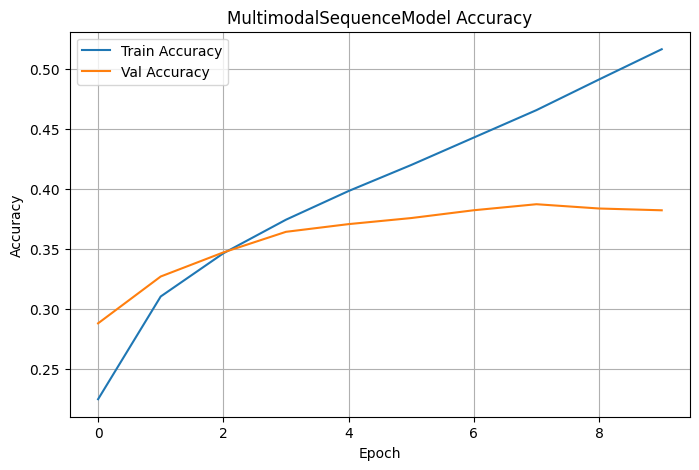

In [ ]:
import matplotlib.pyplot as plt
import os

# Create output directory if it doesn't exist
LOSS_PATH = "/content/drive/MyDrive/Mutimodal_Sequential_prediction/results/Training_accuracy.png"
#os.makedirs(LOSS_PATH, exist_ok=True)

plt.figure(figsize=(8,5))
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("MultimodalSequenceModel Accuracy")
plt.legend()
plt.grid(True)

# Save the figure
LOSS_PATH = os.path.join(RES_DIR, "Training_accuracies.png")
plt.savefig(LOSS_PATH, dpi=300, bbox_inches="tight")

plt.show()


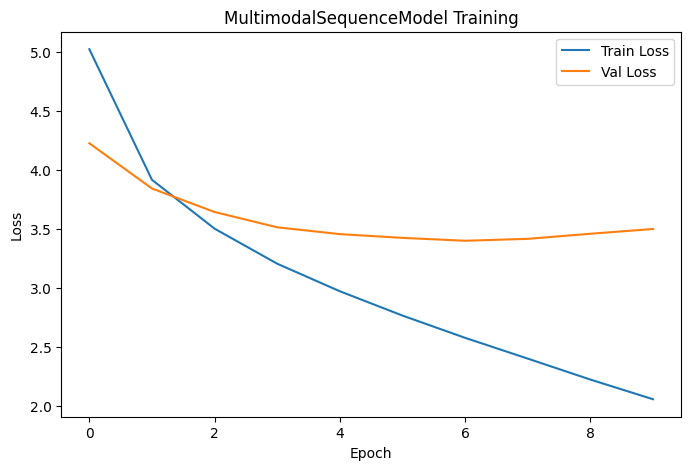

In [ ]:
import os
import matplotlib.pyplot as plt

# Create output directory if it doesn't exist
RES_DIR = "/content/drive/MyDrive/Mutimodal_Sequential_prediction/results"
os.makedirs(RES_DIR, exist_ok=True)

plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("MultimodalSequenceModel Training")
plt.legend()
#plt.grid(True)
# Save the figure
Training_loss_path = os.path.join(RES_DIR, "Training_losses.png")
plt.savefig(Training_loss_path, dpi=300, bbox_inches="tight")

plt.show()

In [ ]:
print("Reusing GLOBAL accelerator:", accelerator.mixed_precision, "grad_accum:", accelerator.gradient_accumulation_steps)
device = accelerator.device

seq_model = MultimodalSequenceModel(latent_dim)
opt = torch.optim.AdamW(seq_model.parameters(), lr=SEQ_LR)

train_dl = DataLoader(StoryDataset("train", MAX_LEN), batch_size=SEQ_BATCH, shuffle=True, num_workers=2, pin_memory=True)
seq_model, opt, train_dl = accelerator.prepare(seq_model, opt, train_dl)

for epoch in range(SEQ_EPOCHS):
    seq_model.train()
    tot = 0.0
    for batch in train_dl:
        imgs3 = batch["imgs224"][:, :3].to(device)
        ids   = batch["ids"].to(device)
        msk   = batch["mask"].to(device)

        _, tokens = seq_model.encode_sequence(imgs3, ids, msk, return_tokens=True)
        loss = mem_collapse_loss(tokens)

        opt.zero_grad(set_to_none=True)
        accelerator.backward(loss)
        opt.step()
        tot += float(loss.detach().cpu())

    accelerator.print(f"Seq Epoch {epoch+1}/{SEQ_EPOCHS} | loss={tot/len(train_dl):.4f}")

accelerator.wait_for_everyone()
if accelerator.is_main_process:
    torch.save(accelerator.unwrap_model(seq_model).state_dict(), SEQ_CKPT_PATH)
    print("saved:", SEQ_CKPT_PATH)


Reusing GLOBAL accelerator: bf16 grad_accum: 2


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Seq Epoch 1/10 | loss=0.0011
Seq Epoch 2/10 | loss=0.0006
Seq Epoch 3/10 | loss=0.0004
Seq Epoch 4/10 | loss=0.0004
Seq Epoch 5/10 | loss=0.0003
Seq Epoch 6/10 | loss=0.0003
Seq Epoch 7/10 | loss=0.0002
Seq Epoch 8/10 | loss=0.0002
Seq Epoch 9/10 | loss=0.0002
Seq Epoch 10/10 | loss=0.0002
saved: /content/drive/MyDrive/Mutimodal_Sequential_prediction/checkpoints/MultimodalSequenceModel.pt


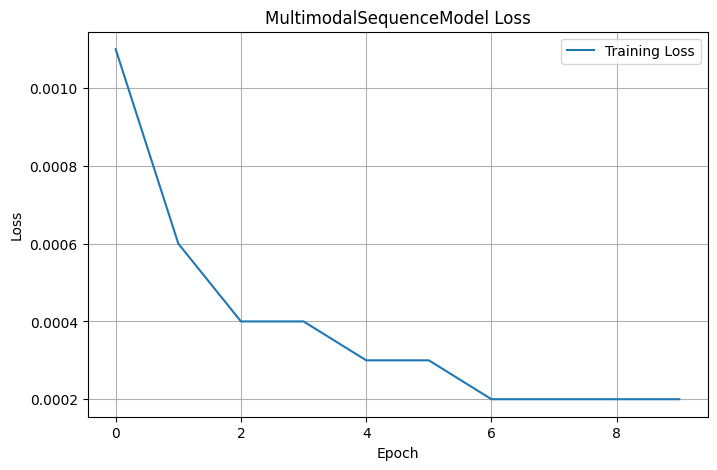

In [ ]:
import matplotlib.pyplot as plt
import os

# Create output directory if it doesn't exist
RES_DIR = "/content/drive/MyDrive/Mutimodal_Sequential_prediction/results"
os.makedirs(RES_DIR, exist_ok=True)

losses_history = [0.0011, 0.0006, 0.0004, 0.0004, 0.0003, 0.0003, 0.0002, 0.0002, 0.0002, 0.0002]
plt.figure(figsize=(8,5))
plt.plot(losses_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("MultimodalSequenceModel Loss")
plt.legend(['Training Loss'])
plt.grid(True)


# Save the figure
FIG_PATH = os.path.join(RES_DIR, "Training_losses.png")
plt.savefig(FIG_PATH, dpi=300, bbox_inches="tight")

plt.show()


Training Loop

# Decoder dataset, Cache & Models

In [ ]:
seq_model = MultimodalSequenceModel(latent_dim).to(DEVICE)
seq_model.load_state_dict(torch.load(SEQ_CKPT_PATH, map_location="cpu"), strict=False)
seq_model.eval()

vae = AutoencoderKL.from_pretrained(SD_MODEL_ID, subfolder="vae").to(DEVICE, dtype=DTYPE)
vae.eval().requires_grad_(False)

def to_minus1_1(x): return x*2.0 - 1.0

@torch.no_grad()
def encode_latents(img_1x3_512):
    x = img_1x3_512.to(DEVICE, dtype=DTYPE)
    if x.min() >= 0 and x.max() <= 1:
        x = to_minus1_1(x)
    lat = vae.encode(x).latent_dist.sample() * 0.18215
    return lat  # (1,4,64,64)

@torch.no_grad()
def build_cache(split="train", max_items=5000):
    dl = DataLoader(StoryDataset(split, MAX_LEN), batch_size=1, shuffle=False, num_workers=2)
    cache = []
    for i, batch in enumerate(dl):
        imgs3 = batch["imgs224"][:, :3].to(DEVICE)
        ids   = batch["ids"].to(DEVICE)
        msk   = batch["mask"].to(DEVICE)

        _, z_tokens = seq_model.encode_sequence(imgs3, ids, msk, return_tokens=True)
        z_tokens = z_tokens[0].detach().float().cpu()  # (3,512)

        gt_lat = encode_latents(batch["gt_img512"]).squeeze(0).detach().float().cpu()


        gt_txt = batch["texts"][3][0]

        cache.append({
            "z_pred": z_tokens,
            "gt_latent": gt_lat,
            "text": str(gt_txt),
        })

        if (i + 1) % 200 == 0:
            print("cached:", i + 1)
        if len(cache) >= max_items:
            break

    torch.save(cache, CACHE_PATH)
    print("Saved cache:", CACHE_PATH, "| items:", len(cache))
    print("Check:", cache[0]["z_pred"].shape,
          cache[0]["gt_latent"].shape,
          "| text:", cache[0]["text"][:80])

build_cache("train", max_items=CACHE_ITEMS)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 197MB/s]


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

cached: 200
cached: 400
cached: 600
cached: 800
cached: 1000
cached: 1200
cached: 1400
cached: 1600
cached: 1800
cached: 2000
cached: 2200
cached: 2400
cached: 2600
cached: 2800
cached: 3000
cached: 3200
cached: 3400
Saved cache: /content/drive/MyDrive/Mutimodal_Sequential_prediction/checkpoints/decoder_cache.pt | items: 3552
Check: torch.Size([3, 512]) torch.Size([4, 64, 64]) | text: The elevator doors open, and Alex stands in the hallway. Alex looks alert, as if


In [ ]:
#Decoder cache dataset
gpt2_tok = GPT2Tokenizer.from_pretrained("gpt2")
gpt2_tok.pad_token = gpt2_tok.eos_token
VOCAB_SIZE = gpt2_tok.vocab_size

class CachedDecoderDataset(torch.utils.data.Dataset):
    def __init__(self, path):
        self.data = torch.load(path, map_location="cpu")
    def __len__(self): return len(self.data)
    def __getitem__(self, i):
        it = self.data[i]
        enc = gpt2_tok(
            str(it["text"]),
            max_length=MAX_LEN,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        )
        return {
            "z_pred": it["z_pred"],                 # (3,512)
            "gt_latent": it["gt_latent"],           # (4,64,64)
            "text_ids": enc.input_ids.squeeze(0),   # (L,)
            "text": str(it["text"])
        }

dec_ds = CachedDecoderDataset(CACHE_PATH)
dec_loader = DataLoader(dec_ds, batch_size=1, shuffle=True, num_workers=2, pin_memory=True)
print("Decoder items:", len(dec_ds))


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Decoder items: 3552


In [ ]:
print("Reusing GLOBAL accelerator:", accelerator.mixed_precision, "grad_accum:", accelerator.gradient_accumulation_steps)
device = accelerator.device

!pip -q install bitsandbytes

import torch
import torch.nn as nn
from diffusers import UNet2DConditionModel, DDPMScheduler
import bitsandbytes as bnb


# UNet
unet = UNet2DConditionModel.from_pretrained(
    SD_MODEL_ID,
    subfolder="unet",
    torch_dtype=torch.float16 if (DEVICE=="cuda") else torch.float32
)

# VRAM Savers
unet.enable_gradient_checkpointing()

#xformers
try:
    unet.enable_xformers_memory_efficient_attention()
    print("xformers enabled")
except Exception as e:
    print("xformers not available:", str(e)[:120])

for p in unet.parameters():
    p.requires_grad = False

trainable_names = []
for name, p in unet.named_parameters():

    # train cross-attn + to_q/to_k/to_v/to_out projections
    if ("attn" in name) or ("to_q" in name) or ("to_k" in name) or ("to_v" in name) or ("to_out" in name):
        p.requires_grad = True
        trainable_names.append(name)

    # also allow last conv_out to adapt slightly
    if "conv_out" in name:
        p.requires_grad = True
        trainable_names.append(name)

print("Trainable UNet params:", len(trainable_names))

#latent_mapper
latent_mapper = nn.Sequential(nn.Linear(512, 768), nn.LayerNorm(768))

# text decoder
class DecoderText(nn.Module):
    def __init__(self, vocab_size, d_model=512, n_layers=3, n_heads=8):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model)
        self.pos   = nn.Embedding(MAX_LEN, d_model)
        layer = nn.TransformerDecoderLayer(
            d_model=d_model, nhead=n_heads, batch_first=True, activation="gelu"
        )
        self.dec = nn.TransformerDecoder(layer, num_layers=n_layers)
        self.out = nn.Linear(d_model, vocab_size)

    def forward(self, input_ids, memory_tokens):
        B, L = input_ids.shape
        pos = torch.arange(L, device=input_ids.device).unsqueeze(0)
        x = self.embed(input_ids) + self.pos(pos)
        causal = nn.Transformer.generate_square_subsequent_mask(L, device=input_ids.device)
        h = self.dec(x, memory_tokens, tgt_mask=causal)
        return self.out(h)

dec_text = DecoderText(VOCAB_SIZE, n_layers=3)

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

# 8-bit optimizer for VRAM
trainable_unet_params = [p for p in unet.parameters() if p.requires_grad]
opt = bnb.optim.AdamW8bit(
    trainable_unet_params + list(latent_mapper.parameters()) + list(dec_text.parameters()),
    lr=DEC_LR
)

unet, latent_mapper, dec_text, opt, dec_loader = accelerator.prepare(
    unet, latent_mapper, dec_text, opt, dec_loader
)

def maybe_drop_condition(cond, p):
    return torch.zeros_like(cond) if random.random() < p else cond

print("Decoder models ready (memory-safe).")


Reusing GLOBAL accelerator: bf16 grad_accum: 2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 15.4 MB/s eta 0:00:00


config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

xformers not available: Refer to https://github.com/facebookresearch/xformers for more information on how to install xformers
Trainable UNet params: 162
Decoder models ready (memory-safe).


In [ ]:
print("Reusing GLOBAL accelerator:", accelerator.mixed_precision, "grad_accum:", accelerator.gradient_accumulation_steps)
device = accelerator.device

Reusing GLOBAL accelerator: bf16 grad_accum: 2


In [ ]:
# Train Decoder
global_step = 0
for epoch in range(DEC_EPOCHS):
    unet.train(); latent_mapper.train(); dec_text.train()
    tot = 0.0

    for batch in dec_loader:
        global_step += 1
        z = batch["z_pred"].to(device)  # (B,T,512)

        lat = batch["gt_latent"].to(device)
        if lat.dim() == 3:
            lat = lat.unsqueeze(0)
        lat = lat.to(dtype=(torch.float16 if MP!="no" and DEVICE=="cuda" else torch.float32))

        txt_ids = batch["text_ids"].to(device)

        noise = torch.randn_like(lat)
        t = torch.randint(0, 1000, (lat.size(0),), device=lat.device).long()
        noisy = noise_scheduler.add_noise(lat, noise, t)

        cond = latent_mapper(z).to(noisy.dtype)
        cond = maybe_drop_condition(cond, CFG_DROP_PROB)

        with accelerator.accumulate(unet):
            opt.zero_grad(set_to_none=True)
            with accelerator.autocast():
                pred_noise = unet(noisy, t, encoder_hidden_states=cond).sample
                img_loss = F.mse_loss(pred_noise, noise)

                logits = dec_text(txt_ids[:, :-1], z)
                text_loss = F.cross_entropy(
                    logits.reshape(-1, VOCAB_SIZE),
                    txt_ids[:, 1:].reshape(-1),
                    ignore_index=gpt2_tok.pad_token_id
                )

                loss = img_loss + text_loss

            accelerator.backward(loss)
            opt.step()

        tot += float(loss.detach().cpu())

    accelerator.print(f"UNet Decoder Epoch {epoch+1}/{DEC_EPOCHS} | loss={tot/len(dec_loader):.4f}")

accelerator.wait_for_everyone()
if accelerator.is_main_process:
    ckpt = {
        "unet": accelerator.unwrap_model(unet).state_dict(),
        "latent_mapper": accelerator.unwrap_model(latent_mapper).state_dict(),
        "dec_text": accelerator.unwrap_model(dec_text).state_dict(),
        "config": {"MAX_LEN": MAX_LEN, "CFG_DROP_PROB": CFG_DROP_PROB, "n_layers_text": 3}
    }
    torch.save(ckpt, DEC_CKPT_PATH)
    print("Saved Option A decoder:", DEC_CKPT_PATH)
    print("Keys:", ckpt.keys())


In [ ]:
# Resume Epoch
import os, torch

DEC_CKPT_PATH = "/content/drive/MyDrive/Mutimodal_Sequential_prediction/checkpoints/decoder_ckpt.pt"

AUTOSAVE_EVERY = 500
global_step = 0

start_epoch  = 6
TOTAL_EPOCHS = 10
BASE_LR      = 1e-4

# load weights-only checkpoint
ckpt = torch.load(DEC_CKPT_PATH, map_location="cpu")
accelerator.unwrap_model(unet).load_state_dict(ckpt["unet"], strict=True)
accelerator.unwrap_model(latent_mapper).load_state_dict(ckpt["latent_mapper"], strict=True)
accelerator.unwrap_model(dec_text).load_state_dict(ckpt["dec_text"], strict=True)
accelerator.print(f"Loaded weights. Resuming epoch {start_epoch}->{TOTAL_EPOCHS}")


optimizer = torch.optim.AdamW(
    list(unet.parameters()) + list(latent_mapper.parameters()) + list(dec_text.parameters()),
    lr=BASE_LR * 0.5
)
optimizer.load_state_dict(ckpt["optimizer"])
unet, latent_mapper, dec_text, optimizer, dec_loader = accelerator.prepare(
    unet, latent_mapper, dec_text, optimizer, dec_loader
)

def set_lr(opt, lr: float):
    for pg in opt.param_groups:
        pg["lr"] = lr

for epoch in range(start_epoch, TOTAL_EPOCHS + 1):
    # LR schedule
    if epoch == start_epoch:
        set_lr(optimizer, BASE_LR * 0.5)
    else:
        set_lr(optimizer, BASE_LR)

    unet.train(); latent_mapper.train(); dec_text.train()
    total = 0.0

    for step, batch in enumerate(dec_loader, start=1):
        global_step += 1

        z = batch["z_pred"].to(accelerator.device)
        lat = batch["gt_latent"].to(accelerator.device)
        txt_ids = batch["text_ids"].to(accelerator.device)

        noise = torch.randn_like(lat)
        t = torch.randint(0, 1000, (lat.size(0),), device=lat.device).long()
        noisy = noise_scheduler.add_noise(lat, noise, t)

        cond = latent_mapper(z).to(noisy.dtype)
        cond = maybe_drop_condition(cond, CFG_DROP_PROB)

        with accelerator.accumulate(unet):
            optimizer.zero_grad(set_to_none=True)
            pred = unet(noisy, t, encoder_hidden_states=cond).sample
            loss = torch.nn.functional.mse_loss(pred, noise)

            accelerator.backward(loss)
            optimizer.step()

        total += loss.item()

        # AUTOSAVE every N steps
        if global_step % AUTOSAVE_EVERY == 0:
            accelerator.wait_for_everyone()
            if accelerator.is_main_process:
                os.makedirs(os.path.dirname(DEC_CKPT_PATH), exist_ok=True)
                autosave_ckpt = {
                    "epoch": epoch,
                    "global_step": global_step,
                    "unet": accelerator.unwrap_model(unet).state_dict(),
                    "latent_mapper": accelerator.unwrap_model(latent_mapper).state_dict(),
                    "dec_text": accelerator.unwrap_model(dec_text).state_dict(),
                    "optimizer": optimizer.state_dict(),
                    "config": {"MAX_LEN": MAX_LEN, "CFG_DROP_PROB": CFG_DROP_PROB, "n_layers_text": 3},
                    "BASE_LR": BASE_LR,
                    "GRAD_ACCUM": GRAD_ACCUM
                }
                torch.save(autosave_ckpt, DEC_CKPT_PATH)
                accelerator.print(
                    f"Autosaved at step {global_step} (epoch {epoch}, step {step})"
                )

    avg_loss = total / max(1, len(dec_loader))
    accelerator.print(
        f"UNet Decoder Epoch {epoch}/{TOTAL_EPOCHS} | loss={avg_loss:.4f} | lr={optimizer.param_groups[0]['lr']:.1e}"
    )

    # Always save at end of epoch
    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        epoch_ckpt = {
            "epoch": epoch,
            "global_step": global_step,
            "unet": accelerator.unwrap_model(unet).state_dict(),
            "latent_mapper": accelerator.unwrap_model(latent_mapper).state_dict(),
            "dec_text": accelerator.unwrap_model(dec_text).state_dict(),
            "optimizer": optimizer.state_dict(),
            "config": {"MAX_LEN": MAX_LEN, "CFG_DROP_PROB": CFG_DROP_PROB, "n_layers_text": 3},
            "BASE_LR": BASE_LR,
            "GRAD_ACCUM": GRAD_ACCUM
        }
        torch.save(epoch_ckpt, DEC_CKPT_PATH)
        accelerator.print(" Epoch checkpoint saved:", DEC_CKPT_PATH)


In [ ]:
UNet Decoder Epoch 1/10 | loss=6.4117
UNet Decoder Epoch 2/10 | loss=6.3634
UNet Decoder Epoch 3/10 | loss=6.3446
UNet Decoder Epoch 4/10 | loss=6.3323
UNet Decoder Epoch 5/10 | loss=6.3237
UNet Decoder Epoch 6/10 | loss=6.3138
UNet Decoder Epoch 7/10 | loss=6.3065
UNet Decoder Epoch 8/10 | loss=6.3020
UNet Decoder Epoch 9/10 | loss=6.3064
UNet Decoder Epoch 10/10 | loss=6.3021

Saved plot to: /content/drive/MyDrive/Multimodal_Sequential_prediction/results/decoder_loss.png


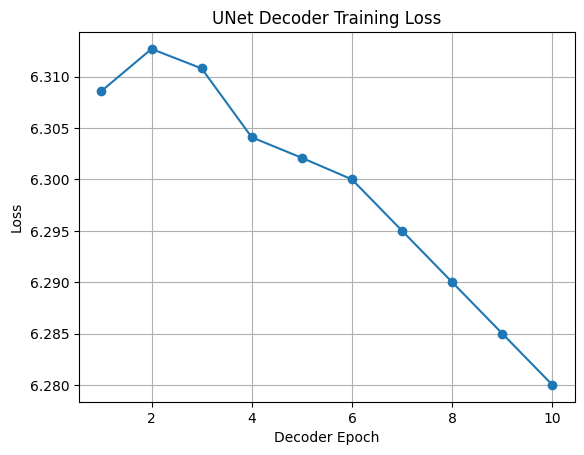

In [ ]:
import os
import matplotlib.pyplot as plt

save_path = "/content/drive/MyDrive/Multimodal_Sequential_prediction/results/decoder_loss.png"
# ensure directory exists
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.figure()

plt.plot(decoder_epoch, loss, marker='o')
plt.xlabel("Decoder Epoch")
plt.ylabel("Loss")
plt.title("UNet Decoder Training Loss")
plt.grid(True)
plt.savefig(save_path, dpi=200, bbox_inches="tight")

print("Saved plot to:", save_path)


In [ ]:
import os
import matplotlib.pyplot as plt

save_path = "/content/drive/MyDrive/Multimodal_Sequential_prediction/results/decoder_loss.png"

# ensure directory exists
os.makedirs(os.path.dirname(save_path), exist_ok=True)

plt.figure()
plt.plot(decoder Epoch, loss, marker='o')
plt.xlabel("Decoder Epoch")
plt.ylabel("Loss")
plt.title("UNet Decoder Training Loss")
plt.grid(True)

plt.savefig(save_path, dpi=200, bbox_inches="tight")
plt.close()

print("Saved plot to:", save_path)


# Visualization


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import textwrap
import torch

def _wrap_text(s, width=42, max_lines=6):
    s = (s or "").replace("\n", " ").strip()
    lines = textwrap.wrap(s, width=width)
    if len(lines) > max_lines:
        lines = lines[:max_lines]
        lines[-1] = lines[-1] + "…"
    return "\n".join(lines)

def _to_u8(img_3hw):
    # img_3hw: torch (3,H,W) in [0,1]
    img_3hw = img_3hw.detach().float().clamp(0, 1).cpu()
    arr = (img_3hw.permute(1,2,0).numpy() * 255.0).round().clip(0,255).astype(np.uint8)
    return arr

@torch.no_grad()
def _vae_encode_latents_dtype_safe(vae, img_1x3_512):
    """
    img_1x3_512: (1,3,512,512) in [0,1]
    returns latents: (1,4,64,64)
    """
    vae_dtype = next(vae.parameters()).dtype
    x = img_1x3_512.to(DEVICE, dtype=vae_dtype)
    x = x * 2.0 - 1.0  # [0,1] -> [-1,1]
    lat = vae.encode(x).latent_dist.sample() * 0.18215
    return lat

@torch.no_grad()
def _vae_decode_latents_dtype_safe(vae, lat_1x4):
    vae_dtype = next(vae.parameters()).dtype
    lat_1x4 = lat_1x4.to(DEVICE, dtype=vae_dtype)
    img = vae.decode(lat_1x4 / 0.18215).sample
    img = ((img + 1) / 2).clamp(0, 1)
    return img  # (1,3,512,512)

@torch.no_grad()
def _ensure_seq_model_on_device(seq_model):
    """
    ResNet/BERT are safest in float32. We force seq_model to DEVICE + float32
    so it won't crash when your inputs are on CUDA.
    """
    seq_model = seq_model.to(DEVICE)
    seq_model = seq_model.float()
    seq_model.eval()
    return seq_model

@torch.no_grad()
def _get_z_tokens_from_seq_model(seq_model, item):
    """
    item keys expected from DNNr.ipynb:
      imgs224: (3,3,224,224)  OR imgs: (3,3,224,224)
      ids:     (3,L)
      mask:    (3,L)
    returns z_tokens: (3,512)
    """
    seq_model = _ensure_seq_model_on_device(seq_model)

    # tolerate either naming convention
    imgs_key = "imgs224" if "imgs224" in item else ("imgs" if "imgs" in item else None)
    if imgs_key is None:
        raise KeyError(f"Expected item['imgs224'] or item['imgs'] but got keys: {list(item.keys())}")

    imgs = item[imgs_key].unsqueeze(0).to(DEVICE).float()  # force float32 for ResNet
    ids  = item["ids"].unsqueeze(0).to(DEVICE)
    mask = item["mask"].unsqueeze(0).to(DEVICE)

    out = seq_model.encode_sequence(imgs, ids, mask, return_tokens=True)
    z_tokens = out[1][0]  # (3,512)
    return z_tokens

@torch.no_grad()
def _predict_text_from_z(dec_text, z_tokens):
    """
    dec_text expects:
      input_ids: (B,L) int64
      memory_tokens: (B,T,512) float (match model dtype)
    """
    # GPT-2 has no BOS token; safest start token is EOS
    start_id = gpt2_tok.bos_token_id
    if start_id is None:
        start_id = gpt2_tok.eos_token_id

    model_dtype = next(dec_text.parameters()).dtype
    mem = z_tokens.unsqueeze(0).to(DEVICE, dtype=model_dtype)  # (1,T,512)

    tokens = torch.tensor([[start_id]], device=DEVICE, dtype=torch.long)
    for _ in range(MAX_LEN - 1):
        logits = dec_text(tokens, mem)                 # (1,L,V)
        nxt = logits[:, -1].argmax(-1, keepdim=True)   # (1,1)
        tokens = torch.cat([tokens, nxt], dim=1)
        if int(nxt.item()) == int(gpt2_tok.eos_token_id):
            break

    return gpt2_tok.decode(tokens[0].tolist(), skip_special_tokens=True)

@torch.no_grad()
def _gt_like_reconstruct_unet(unet, latent_mapper, vae, ddim, z_tokens, gt_lat_1x4, steps=20, strength=0.05):
    """
    GT-like reconstruction:
      start from GT latent, add small noise (strength), denoise with UNet conditioned on z_tokens.
    """
    unet_dtype = next(unet.parameters()).dtype

    z_tokens = z_tokens.unsqueeze(0).to(DEVICE, dtype=unet_dtype)  # (1,T,512)
    cond = latent_mapper(z_tokens).to(dtype=unet_dtype)            # (1,T,768)

    gt_lat = gt_lat_1x4.to(DEVICE, dtype=unet_dtype)

    ddim.set_timesteps(steps, device=DEVICE)

    start = int(strength * steps)
    start = min(max(start, 0), steps - 1)
    t_start = ddim.timesteps[start]

    noise = torch.randn_like(gt_lat)
    lat = ddim.add_noise(gt_lat, noise, t_start)

    for t in ddim.timesteps[start:]:
        t_batch = torch.tensor([int(t)], device=DEVICE, dtype=torch.long)
        eps = unet(lat, t_batch, encoder_hidden_states=cond).sample
        lat = ddim.step(eps, t, lat).prev_sample

    img = _vae_decode_latents_dtype_safe(vae, lat)  # (1,3,512,512)
    return img

def visualize_5panel(idx=0, split="test", steps=20, strength=0.05, width_chars=42):
    """
    5-panel:
      Image1 | Image2 | Image3 | Pred (GT-like) | GT
      Text1  | Text2  | Text3  | Pred Text4     | GT Text4
    """
    ds = StoryDataset(split=split, max_len=MAX_LEN)
    item = ds[idx]

    # DNNr.ipynb keys you showed:
    # dict_keys(['imgs224', 'ids', 'mask', 'texts', 'gt_img512'])
    assert "texts" in item, f"Expected item['texts'] but got keys: {list(item.keys())}"
    texts = item["texts"]
    assert isinstance(texts, (list, tuple)) and len(texts) >= 4, f"item['texts'] must contain 4 strings."

    img1 = item["imgs224"][0]
    img2 = item["imgs224"][1]
    img3 = item["imgs224"][2]
    gt_img4 = item["gt_img512"]  # (3,512,512) in [0,1]

    # ---- z tokens (fixed: moves seq_model to DEVICE float32) ----
    z_tokens = _get_z_tokens_from_seq_model(seq_model, item)  # (3,512)

    # ---- predicted text ----
    pred_txt4 = _predict_text_from_z(dec_text, z_tokens)
    gt_txt4 = str(texts[3])

    # ---- GT latent + GT-like reconstruction ----
    gt_lat = _vae_encode_latents_dtype_safe(vae, gt_img4.unsqueeze(0))  # (1,4,64,64)
    pred_img4 = _gt_like_reconstruct_unet(unet, latent_mapper, vae, ddim, z_tokens, gt_lat,
                                          steps=steps, strength=strength)

    # ---- plot ----
    fig = plt.figure(figsize=(18, 7))

    titles = ["Image 1", "Image 2", "Image 3", "Predicted (GT-like)", "GT"]
    imgs_u8 = [
        _to_u8(img1),
        _to_u8(img2),
        _to_u8(img3),
        _to_u8(pred_img4[0]),
        _to_u8(gt_img4),
    ]

    for i in range(5):
        ax = plt.subplot2grid((2,5), (0,i))
        ax.imshow(Image.fromarray(imgs_u8[i]))
        ax.set_title(titles[i], fontsize=14)
        ax.axis("off")

    txts = [
        _wrap_text(str(texts[0]), width=width_chars, max_lines=7),
        _wrap_text(str(texts[1]), width=width_chars, max_lines=7),
        _wrap_text(str(texts[2]), width=width_chars, max_lines=7),
        _wrap_text(pred_txt4,     width=width_chars, max_lines=7),
        _wrap_text(gt_txt4,       width=width_chars, max_lines=7),
    ]

    labels = ["Text 1","Text 2","Text 3","Pred Text 4","GT Text 4"]
    for i in range(5):
        ax = plt.subplot2grid((2,5), (1,i))
        ax.axis("off")
        ax.text(0.5, 0.95, labels[i], ha="center", va="top", fontsize=12, fontweight="bold")
        ax.text(0.5, 0.05, txts[i], ha="center", va="bottom", fontsize=10)

    plt.tight_layout()
    plt.show()

    print("Predicted text 4:\n", pred_txt4)
    print("\nGT text 4:\n", gt_txt4)


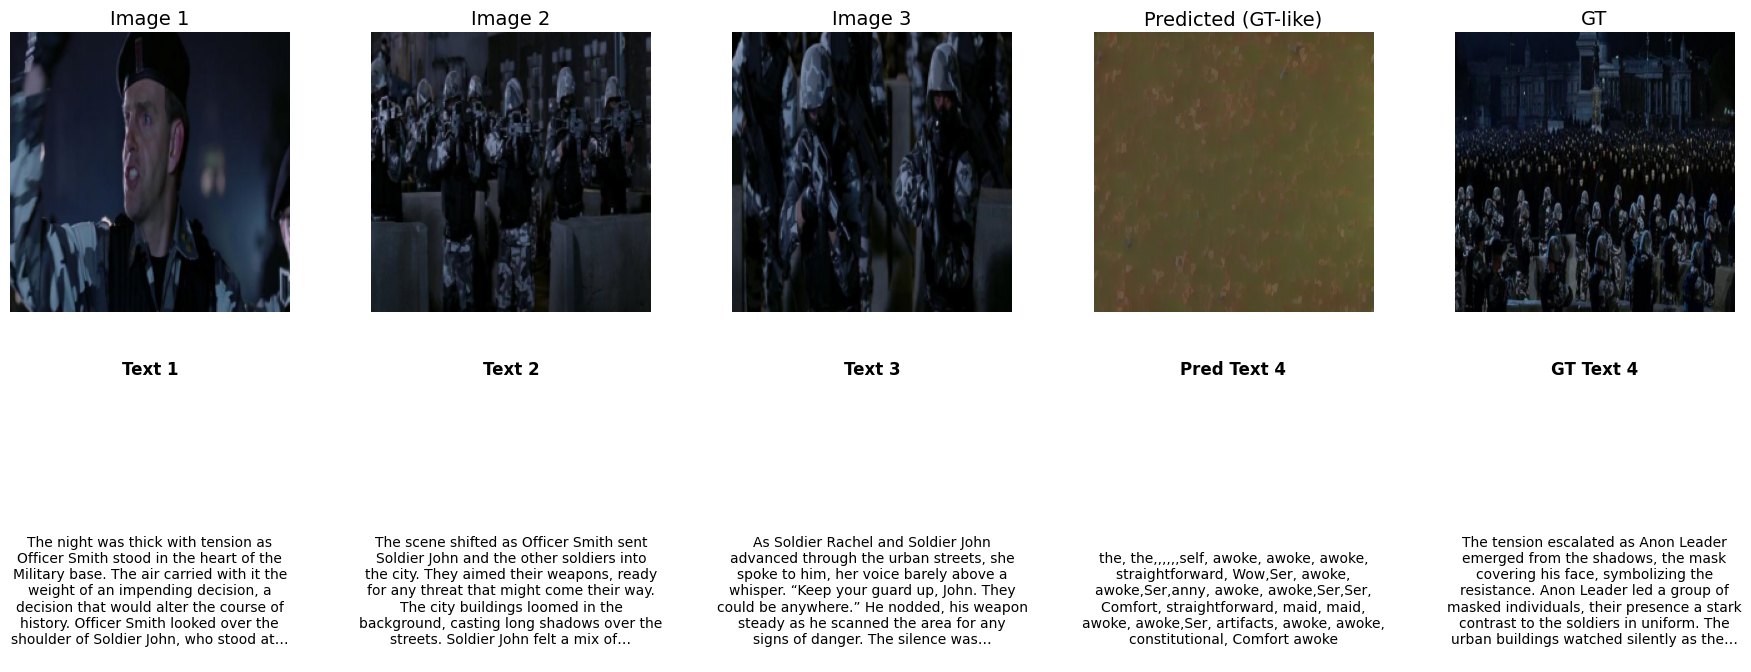

Predicted text 4:
  the, the,,,,,,self, awoke, awoke, awoke, straightforward, Wow,Ser, awoke, awoke,Ser,anny, awoke, awoke,Ser,Ser, Comfort, straightforward, maid, maid, awoke, awoke,Ser, artifacts, awoke, awoke, constitutional, Comfort awoke

GT text 4:
 The tension escalated as Anon Leader emerged from the shadows, the mask covering his face, symbolizing the resistance. Anon Leader led a group of masked individuals, their presence a stark contrast to the soldiers in uniform. The urban buildings watched silently as the two groups faced off. Anon Leader spoke with a determined tone, “We won’t back down, not until our voices are heard.” The soldiers, caught in the moment, wondered what this meant for their mission.


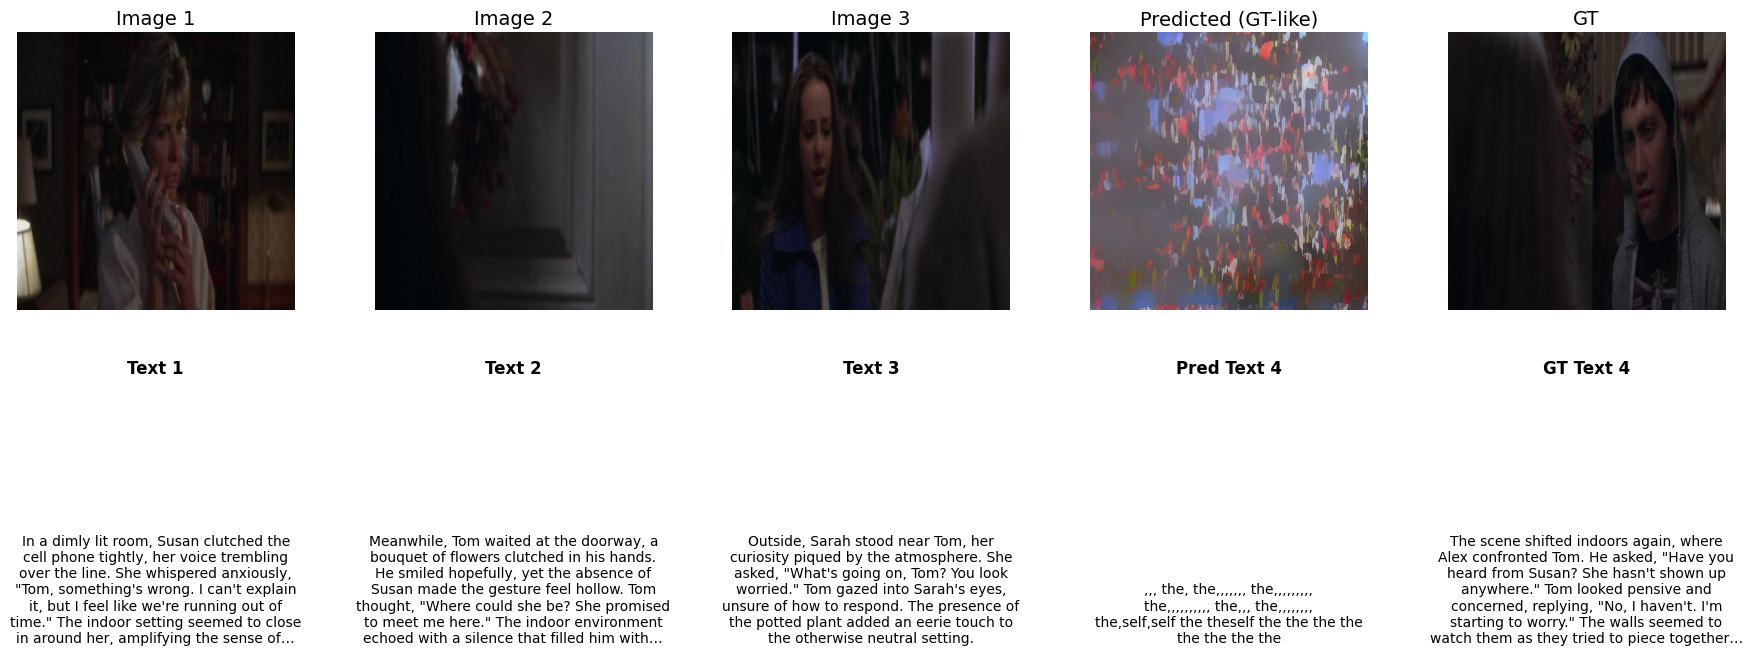

Predicted text 4:
 ,,, the, the,,,,,,, the,,,,,,,,, the,,,,,,,,,, the,,, the,,,,,,,, the,self,self the theself the the the the the the the the

GT text 4:
 The scene shifted indoors again, where Alex confronted Tom. He asked, "Have you heard from Susan? She hasn't shown up anywhere." Tom looked pensive and concerned, replying, "No, I haven't. I'm starting to worry." The walls seemed to watch them as they tried to piece together the puzzle of Susan's disappearance.


In [ ]:
# Result Decoder training at 5 Epoch

visualize_5panel(idx=0, split="test", steps=20, strength=0.05)
visualize_5panel(idx=1, split="test", steps=20, strength=0.05)


Decoder ckpt keys: dict_keys(['unet', 'latent_mapper', 'dec_text', 'config'])


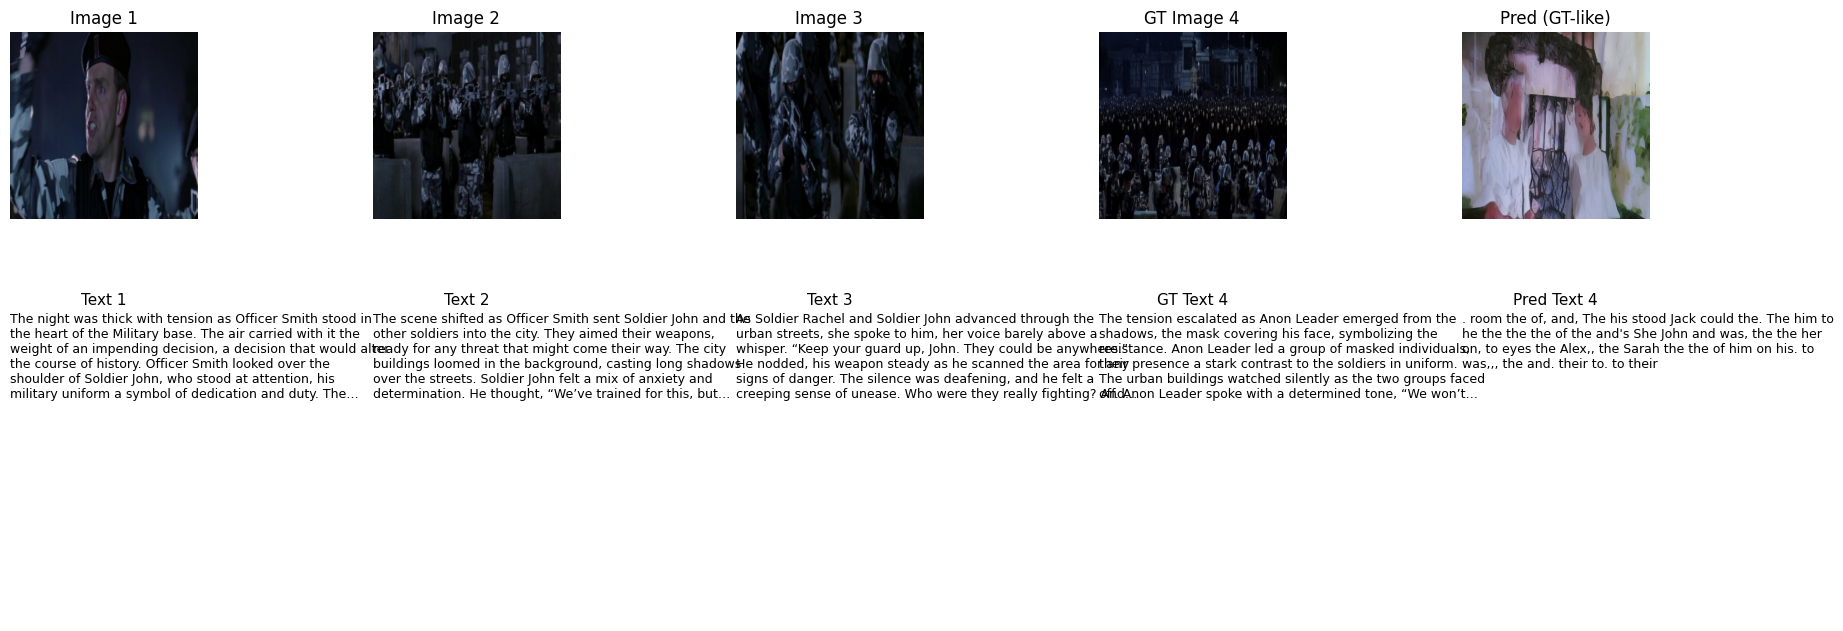


--- TEXT DEBUG ---
GT text 4:
 The tension escalated as Anon Leader emerged from the shadows, the mask covering his face, symbolizing the resistance. Anon Leader led a group of masked individuals, their presence a stark contrast to the soldiers in uniform. The urban buildings watched silently as the two groups faced off. Anon Leader spoke with a determined tone, “We won’t back down, not until our voices are heard.” The soldiers, caught in the moment, wondered what this meant for their mission.

Pred text 4:
 . room the of, and, The his stood Jack could the. The him to he the the the of the and's She John and was, the the her on, to eyes the Alex,, the Sarah the the of him on his. to was,,, the and. their to. to their
Decoder ckpt keys: dict_keys(['unet', 'latent_mapper', 'dec_text', 'config'])


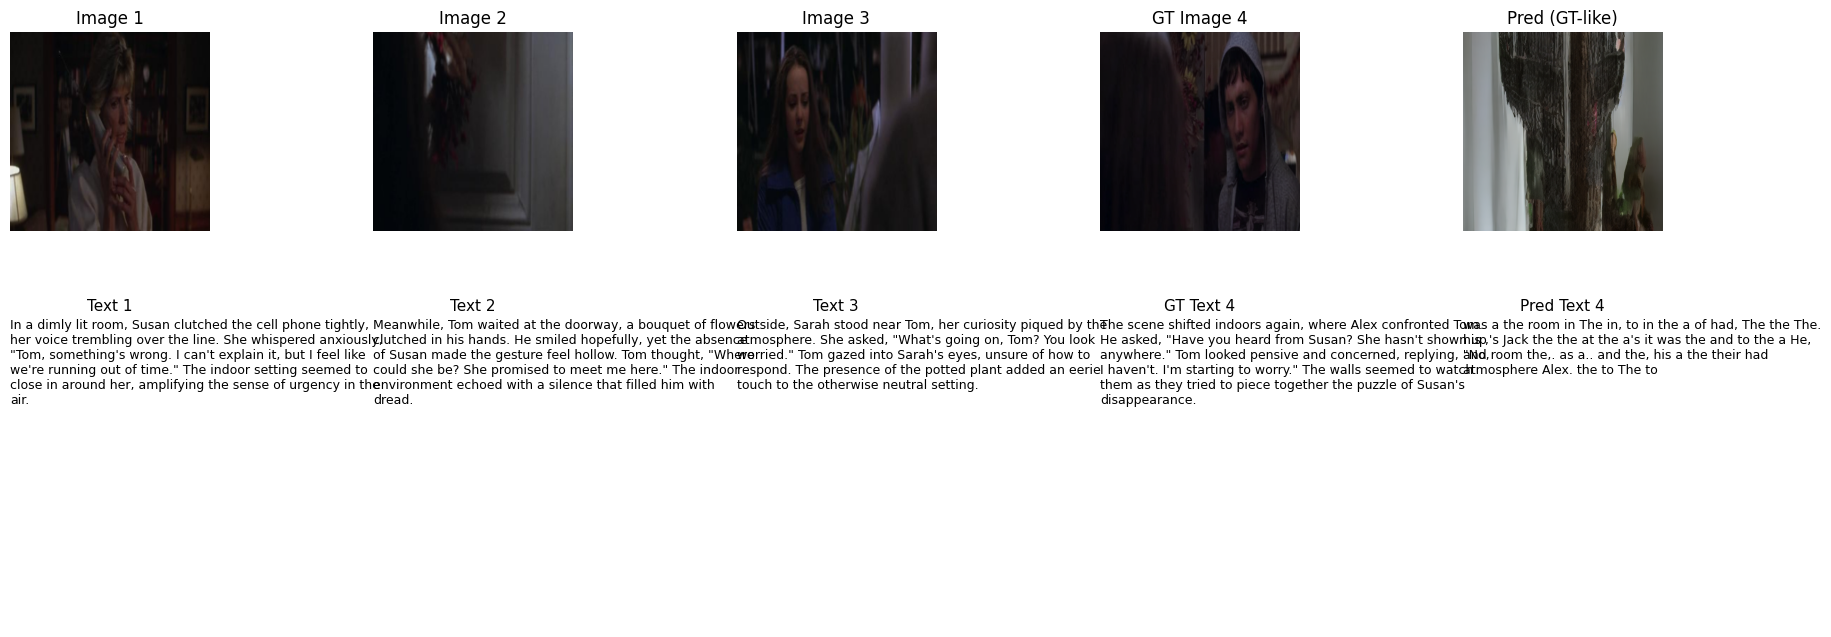


--- TEXT DEBUG ---
GT text 4:
 The scene shifted indoors again, where Alex confronted Tom. He asked, "Have you heard from Susan? She hasn't shown up anywhere." Tom looked pensive and concerned, replying, "No, I haven't. I'm starting to worry." The walls seemed to watch them as they tried to piece together the puzzle of Susan's disappearance.

Pred text 4:
 was a the room in The in, to in the a of had, The the The. his.,'s Jack the the at the a's it was the and to the a He, and room the,. as a.. and the, his a the their had atmosphere Alex. the to The to
Decoder ckpt keys: dict_keys(['unet', 'latent_mapper', 'dec_text', 'config'])


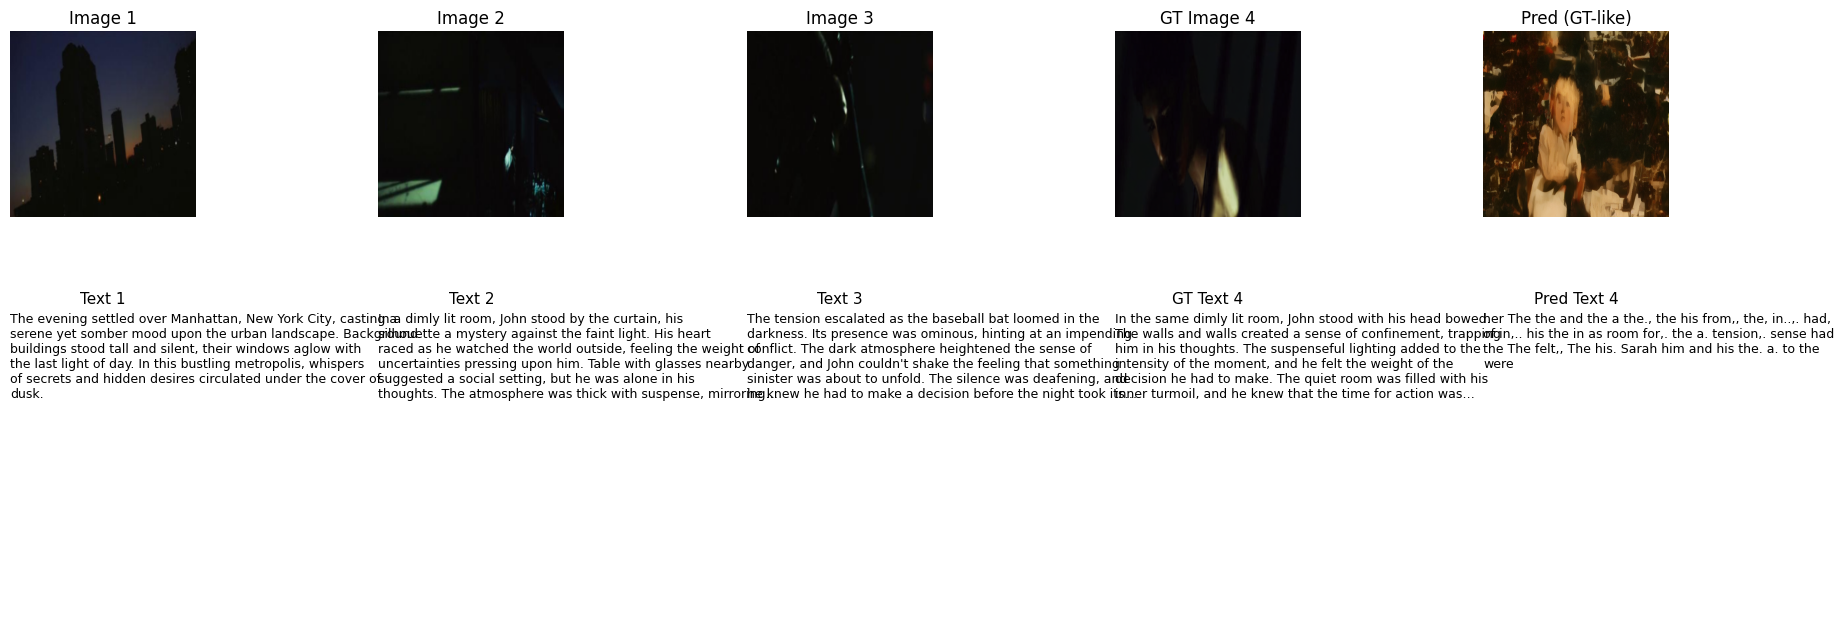


--- TEXT DEBUG ---
GT text 4:
 In the same dimly lit room, John stood with his head bowed. The walls and walls created a sense of confinement, trapping him in his thoughts. The suspenseful lighting added to the intensity of the moment, and he felt the weight of the decision he had to make. The quiet room was filled with his inner turmoil, and he knew that the time for action was near.

Pred text 4:
 her The the and the a the., the his from,, the, in..,. had, of in,.. his the in as room for,. the a. tension,. sense had the The felt,, The his. Sarah him and his the. a. to the were


In [ ]:
# Visualization at 10 Epochs
def show(idx):
    z = dec_ds[idx]["z_pred"]
    visualize_5panel_with_z(
        idx=idx,
        z_tokens=z,
        split="test",
        steps=20,
        strength=0.05
    )

# examples
show(0)
show(1)
show(5)


# Metrics & Ablation

In [ ]:
def to_minus1_1(img01):
    return img01 * 2.0 - 1.0

@torch.no_grad()
def encode_latents(vae, img01_1x3):
    x = img01_1x3.to(DEVICE, dtype=DTYPE)
    x = to_minus1_1(x)
    lat = vae.encode(x).latent_dist.sample() * 0.18215
    return lat  # (1,4,64,64)

@torch.no_grad()
def decode_latents(vae, lat_1x4):
    lat = lat_1x4.to(DEVICE, dtype=DTYPE)
    img = vae.decode(lat / 0.18215).sample
    img = ((img + 1) / 2).clamp(0, 1)
    return img  # (1,3,512,512)

print("encode_latents/decode_latents are now defined.")


In [ ]:
@torch.no_grad()
def gt_like_reconstruct_unet_cfg(
    unet, latent_mapper, vae, ddim,
    z_tokens, gt_lat_1x4,
    steps=20, strength=0.05, cfg_scale=1.0
):
    z = z_tokens.unsqueeze(0).to(DEVICE, dtype=DTYPE)  # (1,T,512)
    cond = latent_mapper(z).to(DEVICE, dtype=DTYPE)    # (1,T,768)
    uncond = torch.zeros_like(cond)

    lat = gt_lat_1x4.to(DEVICE, dtype=DTYPE)

    ddim.set_timesteps(steps, device=DEVICE)
    start = int(strength * steps)
    start = max(0, min(start, steps - 1))
    t_start = ddim.timesteps[start]

    noise = torch.randn_like(lat)
    lat = ddim.add_noise(lat, noise, t_start)

    for t in ddim.timesteps[start:]:
        t_batch = torch.full((1,), int(t), device=DEVICE, dtype=torch.long)

        eps_cond = unet(lat, t_batch, encoder_hidden_states=cond).sample
        if cfg_scale is None or float(cfg_scale) == 1.0:
            eps = eps_cond
        else:
            eps_uncond = unet(lat, t_batch, encoder_hidden_states=uncond).sample
            eps = eps_uncond + float(cfg_scale) * (eps_cond - eps_uncond)

        lat = ddim.step(eps, t, lat).prev_sample

    return decode_latents(vae, lat)  # (1,3,512,512)

print("gt_like_reconstruct_unet_cfg is now defined.")


In [ ]:
from transformers import CLIPProcessor, CLIPModel
import torch.nn.functional as F

class ClipScorer:
    def __init__(self, device):
        self.device = device
        self.model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device).eval()
        self.proc  = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

    @torch.no_grad()
    def image_text_cosine(self, pil_image, text: str) -> float:
        inp = self.proc(
            images=pil_image,
            text=[text],
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=77
        ).to(self.device)

        out = self.model(**inp)
        img = F.normalize(out.image_embeds, dim=-1)
        txt = F.normalize(out.text_embeds, dim=-1)
        return float((img * txt).sum(dim=-1).item())

# recreate instance so ablation uses the patched scorer
clip = ClipScorer(device=DEVICE)
print("CLIP scorer patched + reinitialized")


In [ ]:
IDX = 0
STEPS = 20
STRENGTH = 0.05
CFG_SCALE = 3.0
SPLIT = SPLIT_FOR_VIS

z_tokens = get_z_tokens(IDX)
save_path = os.path.join(PANELS_DIR, f"visualize_5panel_idx{IDX}.png")

out = visualize_5panel_with_z(
    idx=IDX,
    z_tokens=z_tokens,
    split=SPLIT,
    steps=STEPS,
    strength=STRENGTH,
    cfg_scale=CFG_SCALE,
    save_path=save_path,
    show=True
)

print("Saved:", out["save_path"])
print("GT text4:\n", out["gt_text4"])
print("\nPred text4:\n", out["pred_text4"])

# Coherence diagnostics
clip_pp = clip.image_text_cosine(out["pred_pil"], out["pred_text4"])
clip_pg = clip.image_text_cosine(out["pred_pil"], out["gt_text4"])
print("\nCLIP(pred_img, pred_txt):", clip_pp)
print("CLIP(pred_img, gt_txt):  ", clip_pg)


In [ ]:
IDX_LIST = [0, 5, 10]
STEPS_LIST = [10, 20, 30]
STRENGTHS = [0.02, 0.05, 0.10]
CFG_SCALES = [1.0, 3.0, 5.0, 7.0]

CSV_PATH = os.path.join(RES_DIR, "ablation_metrics.csv")

with open(CSV_PATH, "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=[
        "idx","split","steps","strength","cfg_scale",
        "panel_path",
        "clip_predimg_predtxt","clip_predimg_gttxt"
    ])
    writer.writeheader()

    for idx in IDX_LIST:
        z_tokens = get_z_tokens(idx)

        for steps in STEPS_LIST:
            for strength in STRENGTHS:
                for cfg_scale in CFG_SCALES:
                    panel_path = os.path.join(
                        ABL_DIR, f"idx{idx}_steps{steps}_str{strength:.3f}_cfg{cfg_scale:.2f}.png"
                    )

                    out = visualize_5panel_with_z(
                        idx=idx,
                        z_tokens=z_tokens,
                        split=SPLIT_FOR_VIS,
                        steps=steps,
                        strength=strength,
                        cfg_scale=cfg_scale,
                        save_path=panel_path,
                        show=False
                    )

                    clip_pp = clip.image_text_cosine(out["pred_pil"], out["pred_text4"])
                    clip_pg = clip.image_text_cosine(out["pred_pil"], out["gt_text4"])

                    writer.writerow({
                        "idx": idx,
                        "split": SPLIT_FOR_VIS,
                        "steps": steps,
                        "strength": strength,
                        "cfg_scale": cfg_scale,
                        "panel_path": panel_path,
                        "clip_predimg_predtxt": clip_pp,
                        "clip_predimg_gttxt": clip_pg
                    })

                    print(f"[ablate] idx={idx} steps={steps} str={strength:.3f} cfg={cfg_scale:.2f} | "
                          f"CLIP(pp)={clip_pp:.4f} CLIP(pg)={clip_pg:.4f}")

print("Ablation complete")
print("Panels saved to:", ABL_DIR)
print("CSV saved to:", CSV_PATH)


[ablate] idx=0 steps=10 str=0.020 cfg=1.00 | CLIP(pp)=0.2440 CLIP(pg)=0.1939
[ablate] idx=0 steps=10 str=0.020 cfg=3.00 | CLIP(pp)=0.2035 CLIP(pg)=0.1831
[ablate] idx=0 steps=10 str=0.020 cfg=5.00 | CLIP(pp)=0.2752 CLIP(pg)=0.1958
[ablate] idx=0 steps=10 str=0.020 cfg=7.00 | CLIP(pp)=0.2262 CLIP(pg)=0.1982
[ablate] idx=0 steps=10 str=0.050 cfg=1.00 | CLIP(pp)=0.2365 CLIP(pg)=0.2085
[ablate] idx=0 steps=10 str=0.050 cfg=3.00 | CLIP(pp)=0.2340 CLIP(pg)=0.1831
[ablate] idx=0 steps=10 str=0.050 cfg=5.00 | CLIP(pp)=0.2768 CLIP(pg)=0.2037
[ablate] idx=0 steps=10 str=0.050 cfg=7.00 | CLIP(pp)=0.2398 CLIP(pg)=0.2013
[ablate] idx=0 steps=10 str=0.100 cfg=1.00 | CLIP(pp)=0.1930 CLIP(pg)=0.1873
[ablate] idx=0 steps=10 str=0.100 cfg=3.00 | CLIP(pp)=0.2429 CLIP(pg)=0.1987
[ablate] idx=0 steps=10 str=0.100 cfg=5.00 | CLIP(pp)=0.2390 CLIP(pg)=0.1773
[ablate] idx=0 steps=10 str=0.100 cfg=7.00 | CLIP(pp)=0.2769 CLIP(pg)=0.2021
[ablate] idx=0 steps=20 str=0.020 cfg=1.00 | CLIP(pp)=0.2409 CLIP(pg)=0.1780

In [ ]:
# Baseline
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Multimodal_Sequential_prediction/results/ablations")
df.head(10)